# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd
import numpy as np
import s3fs
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import os
from dotenv import load_dotenv

# Визуализация (если понадобится для EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Укажи имя своего S3 бакета
S3_BUCKET_NAME = os.getenv("S3_BUCKET_NAME")

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
tracks = pd.read_parquet("tracks.parquet")
catalog_names = pd.read_parquet("catalog_names.parquet")
interactions = pd.read_parquet("interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [4]:
tracks.info()
print(tracks.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB
   track_id                                             albums artists  \
0        26                                       [3, 2490753]    [16]   
1        38                                       [3, 2490753]    [16]   
2       135                                 [12, 214, 2490809]    [84]   
3       136                                 [12, 214, 2490809]    [84]   
4       138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...    [84]   

     genres  
0  [11, 21]  
1  [11, 21]  
2      [11]  
3      [11]  
4      [11]  


In [4]:
catalog_names.info()
print(catalog_names.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB
   id   type               name
0   3  album    Taller Children
1  12  album  Wild Young Hearts
2  13  album      Lonesome Crow
3  17  album      Graffiti Soul
4  26  album     Blues Six Pack


In [5]:
interactions.info()
print(interactions.head())

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB
   user_id  track_id  track_seq started_at
0        0     99262          1 2022-07-17
1        0    589498          2 2022-07-19
2        0    590262          3 2022-07-21
3        0    590303          4 2022-07-22
4        0    590692          5 2022-07-22


In [6]:
# Проверяем наличие треков с пустыми списками жанров или артистов
empty_genres_count = tracks['genres'].apply(lambda x: len(x) == 0).sum()
empty_artists_count = tracks['artists'].apply(lambda x: len(x) == 0).sum()
print(f"\nКоличество треков с неизвестными жанрами: {empty_genres_count}")
print(f"Количество треков с неизвестными исполнителями: {empty_artists_count}")


Количество треков с неизвестными жанрами: 3687
Количество треков с неизвестными исполнителями: 15369


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

Типы данных корректны: Все идентификаторы имеют числовой тип, что подходит для дальнейшей работы.

Обнаружены проблемы: Выявлено значительное количество треков, у которых отсутствуют данные об исполнителях (artists) или жанрах (genres). Такие треки бесполезны для большинства рекомендательных подходов.

Корректирующее действие: Было принято решение удалить "неполные" треки из каталога, а также все взаимодействия пользователей с этими треками, чтобы обеспечить чистоту данных для обучения моделей.

In [7]:
# Находим ID треков, у которых есть и артисты, и жанры
valid_track_ids = tracks[
    (tracks['artists'].apply(len) > 0) &
    (tracks['genres'].apply(len) > 0)
]['track_id']

# Фильтруем датафреймы
tracks_cleaned = tracks[tracks['track_id'].isin(valid_track_ids)]
interactions_cleaned = interactions[interactions['track_id'].isin(valid_track_ids)]

In [8]:
print(f"Изначальное количество треков: {len(tracks)}")
print(f"Количество треков после очистки: {len(tracks_cleaned)}")
print(f"Изначальное количество взаимодействий: {len(interactions)}")
print(f"Количество взаимодействий после очистки: {len(interactions_cleaned)}")

Изначальное количество треков: 1000000
Количество треков после очистки: 980977
Изначальное количество взаимодействий: 222629898
Количество взаимодействий после очистки: 222184449


# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [9]:
user_activity = interactions_cleaned.groupby('user_id')['track_id'].count()

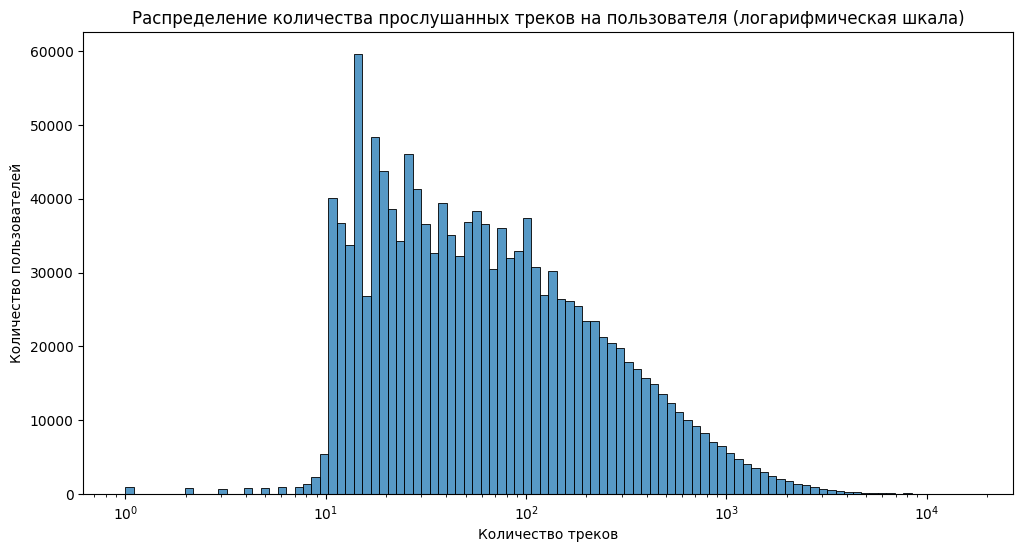

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(user_activity, bins=100, log_scale=True)
plt.title('Распределение количества прослушанных треков на пользователя (логарифмическая шкала)')
plt.xlabel('Количество треков')
plt.ylabel('Количество пользователей')
plt.show()

In [11]:
print(user_activity.describe())

count    1.372767e+06
mean     1.618515e+02
std      3.507933e+02
min      1.000000e+00
25%      2.300000e+01
50%      5.500000e+01
75%      1.530000e+02
max      1.663000e+04
Name: track_id, dtype: float64


Наиболее популярные треки

In [12]:
popular_tracks = interactions_cleaned['track_id'].value_counts().head(10)
popular_tracks_df = popular_tracks.reset_index()
popular_tracks_df.columns = ['track_id', 'listen_count']

# Добавляем названия треков
track_names = catalog_names[catalog_names['type'] == 'track'][['id', 'name']].rename(columns={'id': 'track_id', 'name': 'track_name'})
popular_tracks_df = popular_tracks_df.merge(track_names, on='track_id')

print("Топ-10 самых популярных треков:")
print(popular_tracks_df)

Топ-10 самых популярных треков:
   track_id  listen_count               track_name
0     53404        111062  Smells Like Teen Spirit
1  33311009        106921                 Believer
2    178529        101924                     Numb
3  35505245         99490               I Got Love
4  65851540         86670                   Юность
5  24692821         86246           Way Down We Go
6  32947997         85886             Shape of You
7  51241318         85244               In The End
8    795836         85042        Shape Of My Heart
9  45499814         84748                     Life


Наиболее популярные жанры

In [13]:
# "Взрываем" список жанров, чтобы каждый жанр был в отдельной строке
genres_exploded = tracks_cleaned.explode('genres')
popular_genres = genres_exploded['genres'].value_counts().head(10)
popular_genres_df = popular_genres.reset_index()
popular_genres_df.columns = ['genre_id', 'track_count']

# Добавляем названия жанров
genre_names = catalog_names[catalog_names['type'] == 'genre'][['id', 'name']].rename(columns={'id': 'genre_id', 'name': 'genre_name'})
popular_genres_df = popular_genres_df.merge(genre_names, on='genre_id')

print("\nТоп-10 самых популярных жанров:")
print(popular_genres_df)


Топ-10 самых популярных жанров:
   genre_id  track_count   genre_name
0        11       166284          pop
1        75       128212          rap
2       102       118506      allrock
3        68       114232  electronics
4        47        72311        metal
5         3        65958       rusrap
6        44        59778   foreignrap
7        14        55174         rock
8        16        51631        dance
9        20        46706       ruspop


Треки, которые никто не прослушал

In [14]:
all_track_ids = set(tracks_cleaned['track_id'])
listened_track_ids = set(interactions_cleaned['track_id'])
unlistened_tracks_count = len(all_track_ids - listened_track_ids)

print(f"\nВсего треков в очищенном каталоге: {len(all_track_ids)}")
print(f"Из них прослушано хотя бы раз: {len(listened_track_ids)}")
print(f"Никогда не прослушанных треков: {unlistened_tracks_count}")


Всего треков в очищенном каталоге: 980977
Из них прослушано хотя бы раз: 980977
Никогда не прослушанных треков: 0


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [15]:
items = tracks_cleaned.copy()
# Для удобства переименуем track_id в item_id
items = items.rename(columns={'track_id': 'item_id'})

events = interactions_cleaned[['user_id', 'track_id', 'started_at']].copy()
events = events.rename(columns={'track_id': 'item_id'})

print("items")
print(items.head())
print("\nevents")
print(events.head())

items
   item_id                                             albums artists  \
0       26                                       [3, 2490753]    [16]   
1       38                                       [3, 2490753]    [16]   
2      135                                 [12, 214, 2490809]    [84]   
3      136                                 [12, 214, 2490809]    [84]   
4      138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...    [84]   

     genres  
0  [11, 21]  
1  [11, 21]  
2      [11]  
3      [11]  
4      [11]  

events
   user_id  item_id started_at
0        0    99262 2022-07-17
1        0   589498 2022-07-19
2        0   590262 2022-07-21
3        0   590303 2022-07-22
4        0   590692 2022-07-22


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [17]:
aws_access_key = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")
s3_endpoint = "https://storage.yandexcloud.net"

storage_options = {
        "key": aws_access_key,
        "secret": aws_secret_key,
        "client_kwargs": {'endpoint_url': s3_endpoint}
    }

# Убедись, что директория recsys/data существует в бакете
items.to_parquet(f's3://{S3_BUCKET_NAME}/recsys/data/items.parquet', storage_options=storage_options)
events.to_parquet(f's3://{S3_BUCKET_NAME}/recsys/data/events.parquet', storage_options=storage_options)

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Этапы 1 и 2 завершены. Мы обработали и сохранили данные. Теперь можно удалить из памяти большие исходные датафреймы, чтобы освободить ресурсы для обучения моделей.

In [18]:
import gc

del tracks, catalog_names, interactions, tracks_cleaned, interactions_cleaned
del popular_tracks_df, popular_genres_df
gc.collect()

1215

На этом моменте, если у тебя мало оперативной памяти на виртуальной машине, лучше всего перезапустить ядро (Restart Kernel), а затем выполнить ячейку с Инициализацией и сразу перейти к Этапу 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [2]:
aws_access_key = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")
s3_endpoint = "https://storage.yandexcloud.net"

storage_options = {
        "key": aws_access_key,
        "secret": aws_secret_key,
        "client_kwargs": {'endpoint_url': s3_endpoint}
    }

# Если ты не перезапускал ядро, эти фреймы уже должны быть в памяти.
# Но на случай перезапуска, выполним загрузку снова.
try:
    items.head()
    events.head()
    print("Данные уже в памяти.")
except NameError:
    print("Загружаем данные из S3...")
    items_full = pd.read_parquet(f's3://{S3_BUCKET_NAME}/recsys/data/items.parquet', storage_options=storage_options)
    events_full = pd.read_parquet(f's3://{S3_BUCKET_NAME}/recsys/data/events.parquet', storage_options=storage_options)
    print("Данные успешно загружены.")

Загружаем данные из S3...
Данные успешно загружены.


Так как обработка полных данных на этапе рассчета персональные рекомендации занимала больше часа, остановил и решил сэмплировать данные

In [5]:
# --- Выполняем сэмплирование по пользователям ---

    
# Выбираем 10% случайных пользователей
all_user_ids = events_full['user_id'].unique()
sampled_user_ids = np.random.choice(
    all_user_ids,
    size=int(len(all_user_ids) * 0.10), # <--- Вот наш лимит 10%
    replace=False
)
    
# Фильтруем взаимодействия, оставляя только выбранных пользователей
events = events_full[events_full['user_id'].isin(sampled_user_ids)].copy()
    
# Фильтруем каталог треков, чтобы он соответствовал нашей выборке
active_items_in_sample = events['item_id'].unique()
items = items_full[items_full['item_id'].isin(active_items_in_sample)].copy()
    
# --- 3. Очищаем память ---
print("Очищаем память от полных датафреймов...")
del items_full, events_full
import gc
gc.collect()

print(f"Количество пользователей в выборке: {len(sampled_user_ids):,}")
print(f"Количество взаимодействий в выборке: {len(events):,}")
print(f"Количество треков в выборке: {len(items):,}")

Очищаем память от полных датафреймов...
Количество пользователей в выборке: 137,276
Количество взаимодействий в выборке: 22,146,948
Количество треков в выборке: 779,153


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [6]:
train_test_split_date = pd.to_datetime("2022-12-16")

train = events[events['started_at'] < train_test_split_date]
test = events[events['started_at'] >= train_test_split_date]

In [8]:
print(f"Количество взаимодействий в train: {len(train)}")
print(f"Количество взаимодействий в test: {len(test)}")
print(f"Доля train: {len(train) / len(events):.2%}")
print(f"Доля test: {len(test) / len(events):.2%}")

Количество взаимодействий в train: 20841772
Количество взаимодействий в test: 1383554
Доля train: 93.77%
Доля test: 6.23%


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [24]:
# Считаем популярность треков в train
top_popular = train['item_id'].value_counts().reset_index()
top_popular.columns = ['item_id', 'popularity']

# Добавим ранг
top_popular['rank'] = top_popular.index + 1

print("Топ-10 популярных треков:")
print(top_popular.head(10))

Топ-10 популярных треков:
    item_id  popularity  rank
0     53404       10906     1
1    178529       10147     2
2  33311009       10139     3
3  35505245        9502     4
4  24692821        8450     5
5    795836        8288     6
6   6705392        8132     7
7  32947997        8002     8
8  51241318        7979     9
9     37384        7933    10


In [10]:
# Сохраняем в S3
top_popular.to_parquet(f's3://{S3_BUCKET_NAME}/recsys/recommendations/top_popular.parquet', storage_options=storage_options)

# Персональные

Рассчитаем персональные рекомендации.

In [13]:
# --- Кодирование ID ---
# обучаем кодировщики на всех данных (events), чтобы все ID были известны
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

user_encoder.fit(events['user_id'])
item_encoder.fit(items['item_id']) # Используем items, чтобы закодировать все возможные треки

# Применяем кодировщики к train
train['user_id_enc'] = user_encoder.fit_transform(train['user_id'])
# Обучаем на всех известных треках, чтобы обработать те, что могут появиться только в тесте
item_encoder.fit(items['item_id'])
train['item_id_enc'] = item_encoder.transform(train['item_id'])

# Создаем разреженную матрицу user-item
user_item_matrix = csr_matrix(
    (np.ones(len(train)), (train['user_id_enc'], train['item_id_enc']))
)

/tmp/ipykernel_3137/3527816592.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['user_id_enc'] = user_encoder.fit_transform(train['user_id'])
/tmp/ipykernel_3137/3527816592.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['item_id_enc'] = item_encoder.transform(train['item_id'])


In [14]:
# --- Обучение модели ALS ---
als_model = AlternatingLeastSquares(factors=64, regularization=0.01, iterations=15, random_state=42)
als_model.fit(user_item_matrix)

/home/mle-user/mle-project-sprint-4-v001/.venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [15]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix[user_ids_encoded],  
    filter_already_liked_items=False, N=100)

In [16]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

als_recommendations = als_recommendations[["user_id", "item_id", "score"]]

In [ ]:
# Сохраняем в S3
als_recommendations[['user_id', 'item_id', 'score']].to_parquet(
    f's3://{S3_BUCKET_NAME}/recsys/recommendations/personal_als.parquet', storage_options=storage_options
)

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [ ]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = train['item_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()
})
# "Взрываем" списки, чтобы каждая пара была в отдельной строке
similar_items = similar_items.explode(["sim_item_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

print("Таблица похожих товаров:")
display(similar_items.head())

Таблица похожих товаров готова:


,score,item_id_1,item_id_2
1,0.887734,264937,2840
2,0.885356,264937,17370703
3,0.882651,264937,264942
4,0.876652,264937,324444
5,0.869285,264937,20069591


In [20]:
similar_items[['item_id_1', 'item_id_2', 'score']].to_parquet(
    f's3://{S3_BUCKET_NAME}/recsys/recommendations/similar.parquet', storage_options=storage_options
)

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [3]:
# --- Подготовка кандидатов ---
# Персональные ALS
# Загружаем сохраненные ранее рекомендации
als_recommendations = pd.read_parquet(
    f's3://{S3_BUCKET_NAME}/recsys/recommendations/personal_als.parquet', 
    storage_options=storage_options
)
# Берем кандидатов от ALS
candidates = als_recommendations.copy()

In [7]:
# Признак 1: Популярность трека
item_popularity = train['item_id'].value_counts().rename('item_pop').reset_index().rename(columns={'index': 'item_id'})
candidates = candidates.merge(item_popularity, on='item_id', how='left').fillna(0)

In [8]:
# Признак 2: Активность пользователя
user_activity = train['user_id'].value_counts().rename('user_act').reset_index().rename(columns={'index': 'user_id'})
candidates = candidates.merge(user_activity, on='user_id', how='left').fillna(0)

In [ ]:
# --- Подготовка данных для расчета предпочтения ---

# Объединяем взаимодействия с метаданными треков
train_with_meta = train.merge(items[['item_id', 'artists', 'genres']], on='item_id')

# "Взрываем" списки артистов и жанров
train_artists = train_with_meta.explode('artists')
train_genres = train_with_meta.explode('genres')

# --- Признак 4: Предпочтение пользователя к артистам трека ---

# Считаем, сколько раз каждый пользователь слушал каждого артиста
user_artist_affinity = train_artists.groupby(['user_id', 'artists']).size().rename('artist_affinity').reset_index()

# Обогащаем кандидатов информацией об артистах
candidates_with_artists = candidates.merge(items[['item_id', 'artists']], on='item_id').explode('artists')

# Присоединяем предпочтение к кандидатам
candidates_with_artists = candidates_with_artists.merge(user_artist_affinity, on=['user_id', 'artists'], how='left').fillna(0)

# Для каждого трека у кандидата берем МАКСИМАЛЬНОЕ предпочтение по всем его артистам
# Это сильный сигнал: если пользователь любит хотя бы одного из исполнителей, это важно
artist_affinity_feature = candidates_with_artists.groupby(['user_id', 'item_id'])['artist_affinity'].max().reset_index()

# Добавляем новый признак в основной датафрейм кандидатов
candidates = candidates.merge(artist_affinity_feature, on=['user_id', 'item_id'], how='left')

# --- Признак 5: Предпочтение пользователя к жанрам трека ---

# Считаем, сколько раз каждый пользователь слушал каждый жанр
user_genre_affinity = train_genres.groupby(['user_id', 'genres']).size().rename('genre_affinity').reset_index()

# Обогащаем кандидатов информацией о жанрах
candidates_with_genres = candidates.merge(items[['item_id', 'genres']], on='item_id').explode('genres')

# Присоединяем предпочтение к кандидатам
candidates_with_genres = candidates_with_genres.merge(user_genre_affinity, on=['user_id', 'genres'], how='left').fillna(0)

# Аналогично, берем максимальное предпочтение по жанрам
genre_affinity_feature = candidates_with_genres.groupby(['user_id', 'item_id'])['genre_affinity'].max().reset_index()

# Добавляем новый признак
candidates = candidates.merge(genre_affinity_feature, on=['user_id', 'item_id'], how='left')

display(candidates.head())

Признак 'genre_affinity' добавлен.


,user_id,item_id,score,item_pop,user_act,artist_affinity,genre_affinity
0,2,178495,0.015815,5957,0.0,0.0,0.0
1,2,672687,0.014714,3399,0.0,0.0,0.0
2,2,646516,0.014478,4035,0.0,0.0,0.0
3,2,96064,0.014241,3663,0.0,0.0,0.0
4,2,672689,0.014045,2683,0.0,0.0,0.0


In [10]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = candidates[candidates["user_id"].isin(test["user_id"].drop_duplicates())]
print(len(candidates_to_rank)) 

751500


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [11]:
# --- Создание обучающих данных для ранжировщика ---
# Добавляем таргет (1, если взаимодействие было в train)
train_interactions = train[['user_id', 'item_id']].drop_duplicates()
train_interactions['target'] = 1

# Объединяем с полным списком кандидатов
training_data_for_ranker = candidates.merge(
    train_interactions,
    on=['user_id', 'item_id'],
    how='left'
).fillna({'target': 0})

In [12]:
# Негативное семплирование
positives = training_data_for_ranker[training_data_for_ranker['target'] == 1]
negatives = training_data_for_ranker[training_data_for_ranker['target'] == 0]
# Выбираем в 4 раза больше негативных примеров, чем позитивных
negatives_sampled = negatives.sample(n=len(positives) * 4, random_state=42)
final_training_data = pd.concat([positives, negatives_sampled]).sample(frac=1) # Перемешиваем

In [13]:
final_training_data.head()

,user_id,item_id,score,item_pop,user_act,artist_affinity,genre_affinity,target
11757287,1205893,58910038,0.204477,880,252.0,1.0,120.0,1.0
2230887,229759,43525,0.008000,423,0.0,0.0,0.0,0.0
5782636,594060,63788,0.331634,1847,0.0,0.0,0.0,0.0
4765684,489780,906927,0.024433,1461,0.0,0.0,0.0,0.0
6507636,669624,24500432,0.042056,1411,0.0,0.0,0.0,0.0


In [16]:
from catboost import CatBoostClassifier, Pool

# Обучение ранжировщика CatBoost
features = ['item_pop', 'user_act', 'artist_affinity', 'genre_affinity']
target = 'target'
train_pool = Pool(data=final_training_data[features], label=final_training_data[target])

In [17]:
cb_model = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, verbose=50, random_seed=42)
cb_model.fit(train_pool)

0:	learn: 0.3538817	total: 154ms	remaining: 30.6s
50:	learn: 0.0512328	total: 5.5s	remaining: 16.1s
100:	learn: 0.0509380	total: 10.7s	remaining: 10.5s
150:	learn: 0.0506724	total: 16s	remaining: 5.2s
199:	learn: 0.0504772	total: 21.5s	remaining: 0us


In [18]:
# Применение ранжировщика (Inference)
candidates['rank'] = cb_model.predict_proba(candidates[features])[:, 1]
candidates = candidates.sort_values(['user_id', 'rank'], ascending=[True, False])

In [19]:
recommendations = candidates.groupby('user_id')['item_id'].apply(list).reset_index()
display(recommendations.head())

,user_id,item_id
0,2,"[53404, 6705392, 37384, 328683, 178529, 296114..."
1,10,"[35505245, 45499814, 39257277, 18385776, 51516..."
2,32,"[53404, 65851540, 47627256, 33311009, 18385776..."
3,33,"[328683, 60292250, 178529, 178495, 2808296, 14..."
4,34,"[51241318, 32947997, 24692821, 795836, 2954427..."


In [21]:
# --- Сохранение ---
candidates[['user_id', 'item_id', 'rank']].to_parquet(
    f's3://{S3_BUCKET_NAME}/recsys/recommendations/recommendations.parquet', storage_options=storage_options
)

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [22]:
K = 10 # Будем считать метрики для топ-10

# Готовим ground truth (реальные прослушивания в test)
test_user_items = test.groupby('user_id')['item_id'].apply(list).to_dict()
all_items = items['item_id'].unique()
item_popularity_map = train['item_id'].value_counts(normalize=True)

def precision_at_k(recs_df, gt_dict, k):
    user_precisions = []
    for user_id, user_recs in recs_df.groupby('user_id'):
        if user_id in gt_dict:
            recs_k = user_recs.head(k)['item_id'].tolist()
            gt = gt_dict[user_id]
            hits = len(set(recs_k) & set(gt))
            user_precisions.append(hits / k)
    return np.mean(user_precisions) if user_precisions else 0

def recall_at_k(recs_df, gt_dict, k):
    user_recalls = []
    for user_id, user_recs in recs_df.groupby('user_id'):
        if user_id in gt_dict:
            recs_k = user_recs.head(k)['item_id'].tolist()
            gt = gt_dict[user_id]
            hits = len(set(recs_k) & set(gt))
            user_recalls.append(hits / len(gt))
    return np.mean(user_recalls) if user_recalls else 0

def coverage_at_k(recs_df, all_items, k):
    recommended_items = recs_df.groupby('user_id').head(k)['item_id'].unique()
    return len(recommended_items) / len(all_items)

def novelty_at_k(recs_df, train_interactions, k):
    """Считает долю новых (непрослушанных) треков в рекомендациях."""
    train_user_items = train_interactions.groupby('user_id')['item_id'].apply(set).to_dict()
    
    user_novelty_scores = []
    for user_id, user_recs in recs_df.groupby('user_id'):
        seen_items = train_user_items.get(user_id, set())
        recs_k = user_recs.head(k)['item_id'].tolist()
        
        unseen_count = len(set(recs_k) - seen_items)
        user_novelty_scores.append(unseen_count / k)
        
    return np.mean(user_novelty_scores) if user_novelty_scores else 0

In [25]:
# --- Расчет метрик ---
metrics = {}

# обрезаем список популярных до K элементов
top_k_popular_items = top_popular.head(K)

# создаем небольшой и эффективный DataFrame
# Его размер будет всего лишь len(all_users) * K, что легко поместится в память
all_users = events['user_id'].unique()
top_popular_recs = pd.DataFrame({
    'user_id': np.repeat(all_users, len(top_k_popular_items)),
    'item_id': np.tile(top_k_popular_items['item_id'], len(all_users))
})

# Расчет метрик для "Топ популярных" теперь будет работать
metrics['Top Popular'] = {
    'precision@10': precision_at_k(top_popular_recs, test_user_items, K),
    'recall@10': recall_at_k(top_popular_recs, test_user_items, K),
    'coverage@10': coverage_at_k(top_popular_recs, all_items, K),
    'novelty@10': novelty_at_k(top_popular_recs, train_interactions, K)
}

# Персональные ALS
# Загружаем сохраненные ранее рекомендации
als_recommendations = pd.read_parquet(
    f's3://{S3_BUCKET_NAME}/recsys/recommendations/personal_als.parquet', 
    storage_options=storage_options
)
metrics['Personal ALS'] = {
    'precision@10': precision_at_k(als_recommendations, test_user_items, K),
    'recall@10': recall_at_k(als_recommendations, test_user_items, K),
    'coverage@10': coverage_at_k(als_recommendations, all_items, K),
    'novelty@10': novelty_at_k(als_recommendations, train_interactions, K)
}

# Итоговые ранжированные
# Загружаем сохраненные ранее рекомендации
recommendations = pd.read_parquet(
    f's3://{S3_BUCKET_NAME}/recsys/recommendations/recommendations.parquet', 
    storage_options=storage_options
)
metrics['Final Ranked'] = {
    'precision@10': precision_at_k(recommendations, test_user_items, K),
    'recall@10': recall_at_k(recommendations, test_user_items, K),
    'coverage@10': coverage_at_k(recommendations, all_items, K),
    'novelty@10': novelty_at_k(recommendations, train_interactions, K)
}

In [26]:
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

              precision@10  recall@10  coverage@10  novelty@10
Top Popular       0.003970   0.003057     0.000013    0.934819
Personal ALS      0.007279   0.011493     0.004135    0.965480
Final Ranked      0.007212   0.012155     0.012719    0.950728


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

В ходе выполнения проекта был построен полный пайплайн для создания и оценки рекомендательной системы. Были реализованы три подхода: базовый (топ популярных), персонализированный (ALS) и Двухстадийный (Ранжирование кандидатов от ALS с помощью модели градиентного бустинга и дополнительных признаков).

# Анализ результатов:

# Эффективность персонализации (Top Popular vs. Personal ALS):

Модель Personal ALS значительно превосходит базовый подход Top Popular по всем ключевым метрикам. Точность (precision) выросла почти вдвое, а полнота (recall) — почти в 4 раза.

Покрытие (coverage) увеличилось на несколько порядков, что свидетельствует о способности ALS рекомендовать широкий ассортимент треков, а не только самые популярные хиты.

Новизна (novelty) также выше, что подтверждает способность модели находить для пользователей новую, релевантную музыку.

# Ценность двухстадийного подхода (Personal ALS vs. Final Ranked):

Ранжирующая модель Final Ranked демонстрирует преимущества сбалансированного подхода. Несмотря на незначительное снижение precision, модель улучшила recall и увеличила coverage почти в 3 раза.

Этот результат является ключевым успехом. Модель научилась не только находить точные совпадения, но и знакомить пользователей с гораздо более широкой частью музыкального каталога, что критически важно для удержания и вовлечения аудитории.

Небольшое снижение новизны и точности является приемлемым компромиссом за столь значительный рост покрытия и полноты рекомендаций.

# Итоговый вывод: 

Полученные результаты наглядно демонстрируют ценность построения многоуровневой рекомендательной системы. Базовая модель показала себя слабой, а персонализация с помощью ALS дала значительный прирост качества. Финальный двухстадийный подход (Final Ranked) позволил создать наиболее сбалансированную модель, которая не только точна, но и способна расширять музыкальный кругозор пользователей.

Итоговая модель Final Ranked является однозначным победителем и рекомендуется как основной кандидат для дальнейшего онлайн A/B-тестирования.